### Importing Libraries

In [161]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer
import string
import emoji
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from imblearn.under_sampling import RandomUnderSampler
from gensim.models import Word2Vec
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from warnings import filterwarnings
import pickle
filterwarnings('ignore')

In [110]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\balde\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\balde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Loading the Data

In [111]:
df = pd.read_csv("Sentiment_Data.csv",encoding='latin-1')

In [112]:
df.head()

,Tweet,Sentiment
0,@_angelica_toy Happy Anniversary!!!....The Day...,Mild_Pos
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,Mild_Pos
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,Mild_Pos
3,@NChartierET Happy Anniversary!!!....The Day t...,Mild_Pos
4,@tabithapeters05 Happy Anniversary!!!....The D...,Mild_Pos


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451332 entries, 0 to 451331
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Tweet      451331 non-null  object
 1   Sentiment  451332 non-null  object
dtypes: object(2)
memory usage: 6.9+ MB


#### Handling null values

In [114]:
df.isnull().sum()

Tweet        1
Sentiment    0
dtype: int64

In [115]:
df.dropna(inplace=True)

#### Handling duplicates

In [116]:
df[df.duplicated()].count()

Tweet        36
Sentiment    36
dtype: int64

In [117]:
df.drop_duplicates(inplace=True)

In [118]:
#### Resetting the index
df.reset_index(drop=True, inplace=True)

In [119]:
df.Sentiment.value_counts()

Sentiment
Strong_Pos    233674
Neutral        77012
Mild_Pos       64000
Strong_Neg     42555
Mild_Neg       34054
Name: count, dtype: int64

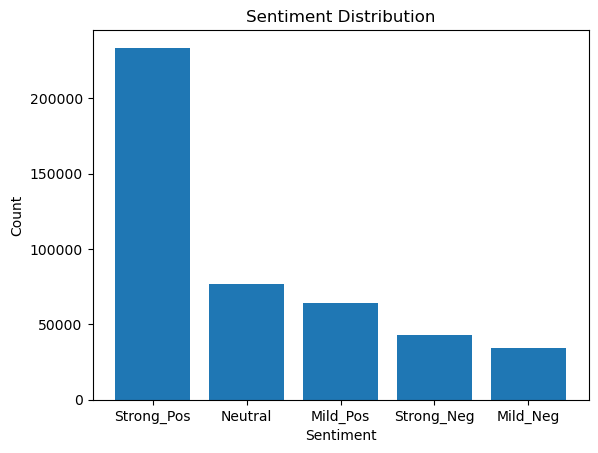

In [120]:
plt.bar(x=df.Sentiment.value_counts().index, height=df.Sentiment.value_counts().values)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")
plt.show()

- Merging Strong_Pos and Mid_Pos into Positive and Strong_Neg and Mild_Neg into Negative

In [121]:
df['Sentiment'] = df.Sentiment.replace({'Strong_Pos': 'Positive', 'Neutral': 'Neutral', 'Mild_Pos': 'Positive', 'Strong_Neg': 'Negative', 'Mild_Neg': 'Negative'})

In [122]:
df.Sentiment.value_counts()

Sentiment
Positive    297674
Neutral      77012
Negative     76609
Name: count, dtype: int64

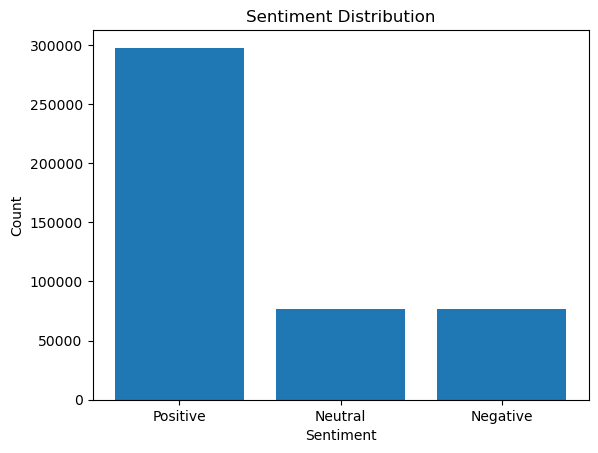

In [123]:
plt.bar(x=df.Sentiment.value_counts().index, height=df.Sentiment.value_counts().values)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")
plt.show()

### Pre-processing

In [124]:
## Slang dictionary
slang_dic = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    'ur' : 'you are',
    'lol' : 'laughing out loud',
    'wth' : 'what the hell',    
    "mightn't": "might not",
}

In [125]:
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
stop_words_set = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
punctuation = set(string.punctuation)

In [126]:
def removal_html(text):
    return re.sub(r'<.*?>','',text)
def removal_url(text):
    clean_text = re.sub(r'https?:\/\/[^\s]+','',text)
    return re.sub(r'www\.[a-z]?\.?(com)+|[a-z]*?\.?(com)+','',clean_text)
def twitter_handles(text):
    return re.sub(r'@\w*','',text)

In [127]:
def pre_processing(text):
    # Handle emojis
    text = emoji.demojize(text)

    # Replace slang and abbreviations
    text = ' '.join([slang_dic.get(word, word) for word in text.split()])

    # handling twitter handles
    text = twitter_handles(text)

    # removal of urls and www sites
    text = removal_url(text)      

    # removal of html tags       
    text = removal_html(text)            

    #Remove hastags but keep the text
    text = re.sub(r'#','',text)

    #Remove numbers but keep the text
    text = re.sub(r'\d+','',text)

    # Remove punctuation and stopwords
    text = ''.join([char if char not in punctuation else ' ' for char in text])
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words_set])

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)

    return text

In [128]:
df['Preprocessed_Tweet'] = df['Tweet'].apply(pre_processing)


In [129]:
df.head()

,Tweet,Sentiment,Preprocessed_Tweet
0,@_angelica_toy Happy Anniversary!!!....The Day...,Positive,Happy Anniversary Day FreeDUMB Died tune McLea...
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,Positive,Happy Anniversary Day FreeDUMB Died tune McLea...
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,Positive,Happy Anniversary Day FreeDUMB Died tune McLea...
3,@NChartierET Happy Anniversary!!!....The Day t...,Positive,Happy Anniversary Day FreeDUMB Died tune McLea...
4,@tabithapeters05 Happy Anniversary!!!....The D...,Positive,Happy Anniversary Day FreeDUMB Died tune McLea...


In [130]:
def post_processing(text):
    # Tokenize using TweetTokenizer
    tokens = tokenizer.tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word.lower() not in stop_words_set]

    # Lemmatize each token
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Convert tokens back to text (lowercased)
    text = ' '.join(tokens).lower()

    return text

In [131]:
df['Final_Tweet'] = df['Preprocessed_Tweet'].apply(post_processing)

### Feature Engineering

In [132]:
X = df['Final_Tweet']  # Features
y = df['Sentiment']        # Labels

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [134]:
X_train_reshaped = X_train.values.reshape(-1, 1)

In [135]:
# Initialize the undersampler
undersampler = RandomUnderSampler(sampling_strategy='auto')

# Apply undersampling
X_train, y_train = undersampler.fit_resample(X_train_reshaped, y_train)

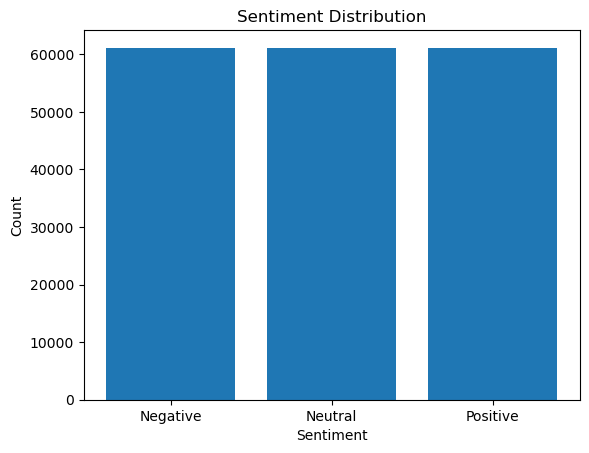

In [136]:
plt.bar(x=y_train.value_counts().index, height=y_train.value_counts().values)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")
plt.show()

### Modelling

In [137]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [138]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Accuracy: ", accuracy_score(y_test, y_pred)) 
    print("Precision: ", precision_score(y_test, y_pred, average='weighted'))
    print("Recall: ", recall_score(y_test, y_pred, average='weighted'))
    print("F1 score: ", f1_score(y_test, y_pred, average='weighted'))
    print("F1 Score (Positive): ", f1_score(y_test, y_pred, pos_label='Positive',average='macro'))
    print("F1 Score (Negative): ", f1_score(y_test, y_pred, pos_label='Negative',average='macro'))
    print("F1 Score (Neutral): ", f1_score(y_test, y_pred, pos_label='Neutral',average='macro'))
    print("Confusion matrix: \n", confusion_matrix(y_test, y_pred))
    print("Classification report: \n", classification_report(y_test, y_pred))

#### SVM with Count Vectorizer (Unigram)

In [139]:
X_train.shape

(183402, 1)

In [140]:
X_train = X_train.reshape(-1) 

In [141]:

# Unigram Count Vectorizer
count_vectorizer = CountVectorizer(ngram_range=(1, 1))

# Build a pipeline with CountVectorizer and SVM
svm_count = make_pipeline(count_vectorizer, LinearSVC())

# Train the model
svm_count.fit(X_train, y_train)

# Predict and evaluate on test set
y_pred = svm_count.predict(X_test)

In [142]:
evaluate_model(svm_count, X_test, y_test)

Accuracy:  0.7627272626552477
Precision:  0.7929776618075772
Recall:  0.7627272626552477
F1 score:  0.7731357417436605
F1 Score (Positive):  0.6889539785341251
F1 Score (Negative):  0.6889539785341251
F1 Score (Neutral):  0.6889539785341251
Confusion matrix: 
 [[11199  2732  1544]
 [ 3245  9584  2547]
 [ 4665  6683 48060]]
Classification report: 
               precision    recall  f1-score   support

    Negative       0.59      0.72      0.65     15475
     Neutral       0.50      0.62      0.56     15376
    Positive       0.92      0.81      0.86     59408

    accuracy                           0.76     90259
   macro avg       0.67      0.72      0.69     90259
weighted avg       0.79      0.76      0.77     90259



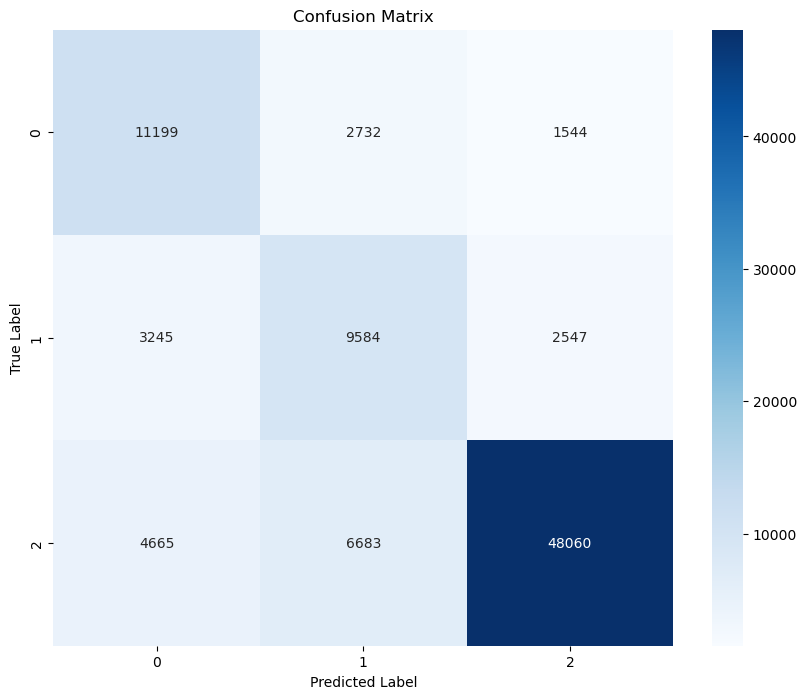

In [143]:
plot_confusion_matrix(y_test, y_pred)

In [162]:
with open('svm_count.pkl', 'wb') as file:
    pickle.dump(svm_count, file)

#### SVM model using TF-IDF with Unigram+Bigram

In [144]:
# Unigram + Bigram TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# Build a pipeline with TF-IDF Vectorizer and SVM
svm_tfidf = make_pipeline(tfidf_vectorizer, LinearSVC())

# Train the model
svm_tfidf.fit(X_train, y_train)

# Predict and evaluate on test set
y_pred = svm_tfidf.predict(X_test)


In [145]:
evaluate_model(svm_tfidf, X_test, y_test)

Accuracy:  0.7805537397932616
Precision:  0.8151250295647944
Recall:  0.7805537397932616
F1 score:  0.7902998404836328
F1 Score (Positive):  0.716454900381181
F1 Score (Negative):  0.716454900381181
F1 Score (Neutral):  0.716454900381181
Confusion matrix: 
 [[12660  1689  1126]
 [ 3536  9875  1965]
 [ 6256  5235 47917]]
Classification report: 
               precision    recall  f1-score   support

    Negative       0.56      0.82      0.67     15475
     Neutral       0.59      0.64      0.61     15376
    Positive       0.94      0.81      0.87     59408

    accuracy                           0.78     90259
   macro avg       0.70      0.76      0.72     90259
weighted avg       0.82      0.78      0.79     90259



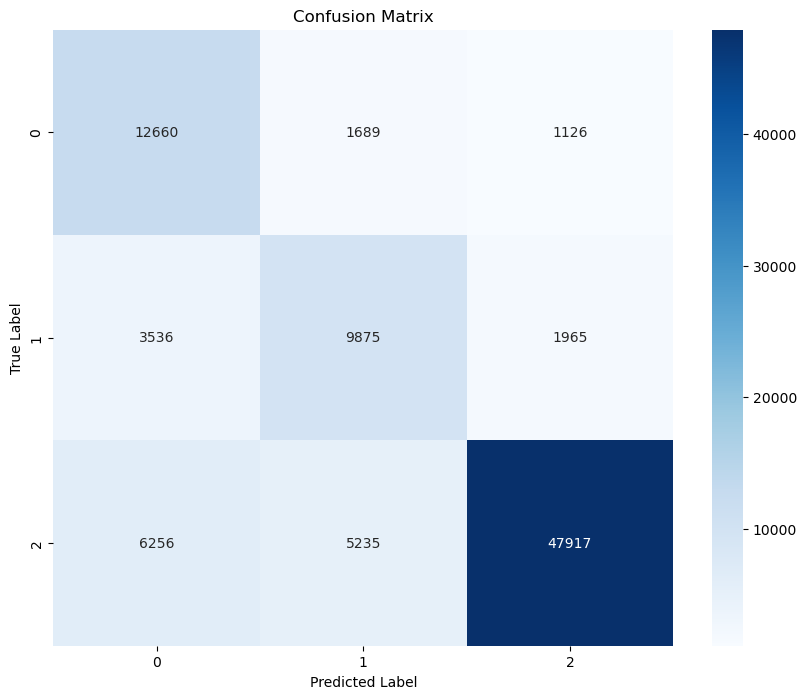

In [146]:
plot_confusion_matrix(y_test, y_pred)

In [163]:
with open('svm_tfidf.pkl', 'wb') as file:
    pickle.dump(svm_tfidf, file)

#### Naive Bayes model using One-Hot Vectors for Unigram+Bigram

In [147]:
# One-Hot Vectorizer (Unigram + Bigram)
count_vectorizer_bigram = CountVectorizer(ngram_range=(1, 2))

# Build a pipeline with CountVectorizer and Naive Bayes
nb_onehot = make_pipeline(count_vectorizer_bigram, MultinomialNB())

# Train the model
nb_onehot.fit(X_train, y_train)

# Predict and evaluate on test set
y_pred = nb_onehot.predict(X_test)
print("Naive Bayes with One-Hot Encoding (Unigram + Bigram)")


Naive Bayes with One-Hot Encoding (Unigram + Bigram)


In [148]:
evaluate_model(nb_onehot, X_test, y_test)

Accuracy:  0.7158288924096212
Precision:  0.7805672390708674
Recall:  0.7158288924096212
F1 score:  0.7318968941468762
F1 Score (Positive):  0.649032565424189
F1 Score (Negative):  0.649032565424189
F1 Score (Neutral):  0.649032565424189
Confusion matrix: 
 [[12552  1363  1560]
 [ 4890  8154  2332]
 [11270  4234 43904]]
Classification report: 
               precision    recall  f1-score   support

    Negative       0.44      0.81      0.57     15475
     Neutral       0.59      0.53      0.56     15376
    Positive       0.92      0.74      0.82     59408

    accuracy                           0.72     90259
   macro avg       0.65      0.69      0.65     90259
weighted avg       0.78      0.72      0.73     90259



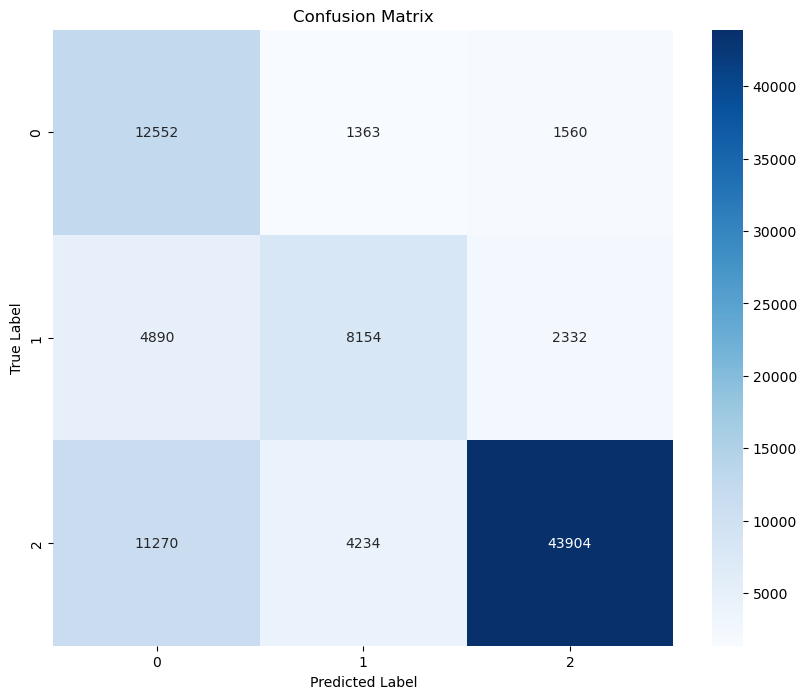

In [149]:
plot_confusion_matrix(y_test, y_pred)

In [164]:
with open('nb_onehot.pkl', 'wb') as file:
    pickle.dump(nb_onehot, file)

#### SVM Model using word2vec (CBOW and  vector size 300)

In [150]:
# Tokenize the tweets into lists of words (for Word2Vec training)
X_train_tokens = [text.split() for text in X_train]

# Train Word2Vec model (CBOW with vector size 300)
word2vec_model = Word2Vec(sentences=X_train_tokens, vector_size=300, window=5, sg=0, min_count=1)


In [151]:
word2vec_model.wv.most_similar(positive="danger")

[('destruction', 0.7640016674995422),
 ('assassination', 0.7391704320907593),
 ('intimidation', 0.7374558448791504),
 ('interest', 0.7370269894599915),
 ('existential', 0.736819326877594),
 ('experienced', 0.7345383167266846),
 ('undermining', 0.7329707741737366),
 ('disregard', 0.7265174984931946),
 ('discourse', 0.7203857898712158),
 ('responsible', 0.7198503017425537)]

In [152]:
word2vec_model.wv.most_similar(positive="happy")

[('quiet', 0.7484598159790039),
 ('celebrate', 0.7278443574905396),
 ('late', 0.7204626202583313),
 ('grateful', 0.7121954560279846),
 ('forever', 0.7103524804115295),
 ('beautiful', 0.6992485523223877),
 ('bigger', 0.6874948740005493),
 ('wish', 0.6843989491462708),
 ('wondering', 0.6817559003829956),
 ('inconvenienced', 0.6808760762214661)]

In [165]:
# Function to get the average Word2Vec embedding for a tweet
def get_average_word2vec(tokens, model, vector_size):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Convert X_train and X_test to Word2Vec embeddings
X_train_w2v = np.array([get_average_word2vec(text.split(), word2vec_model, 300) for text in X_train])
X_test_w2v = np.array([get_average_word2vec(text.split(), word2vec_model, 300) for text in X_test])

# Train the SVM model on Word2Vec embeddings
svm_w2v = LinearSVC()
svm_w2v.fit(X_train_w2v, y_train)

# Predict and evaluate
y_pred = svm_w2v.predict(X_test_w2v)
print("SVM with Word2Vec Embeddings")


SVM with Word2Vec Embeddings


In [166]:
evaluate_model(svm_w2v, X_test_w2v, y_test)

Accuracy:  0.7108875569195315
Precision:  0.7555878301644828
Recall:  0.7108875569195315
F1 score:  0.7234660610123036
F1 Score (Positive):  0.6290542032607641
F1 Score (Negative):  0.6290542032607641
F1 Score (Neutral):  0.6290542032607641
Confusion matrix: 
 [[11529  1854  2092]
 [ 4777  7468  3131]
 [ 9050  5191 45167]]
Classification report: 
               precision    recall  f1-score   support

    Negative       0.45      0.75      0.56     15475
     Neutral       0.51      0.49      0.50     15376
    Positive       0.90      0.76      0.82     59408

    accuracy                           0.71     90259
   macro avg       0.62      0.66      0.63     90259
weighted avg       0.76      0.71      0.72     90259



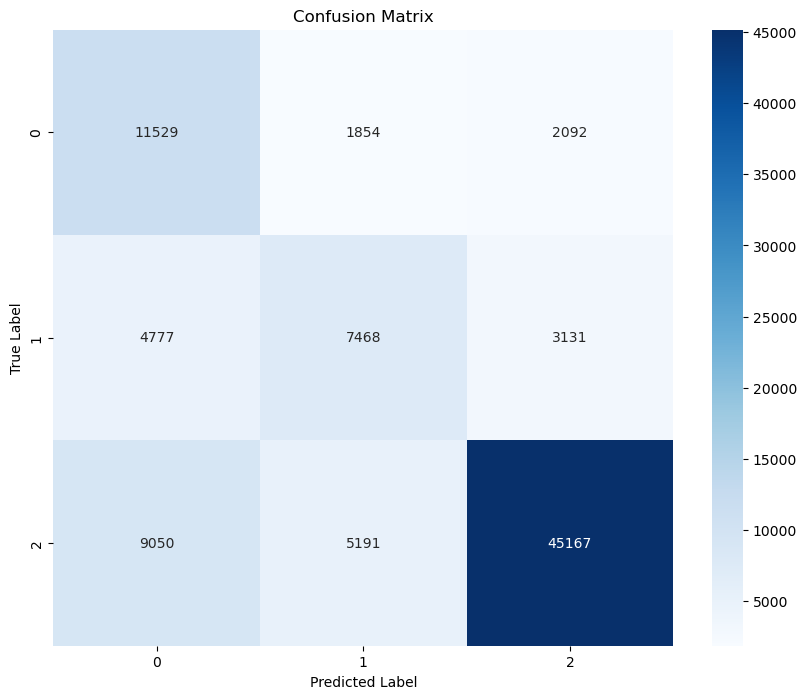

In [167]:
plot_confusion_matrix(y_test, y_pred)

In [168]:
with open('svm_w2v.pkl', 'wb') as file:
    pickle.dump(svm_w2v, file)

#### SVM Model using word2vec (Skipgram and any vector size 300)

In [169]:
# Tokenize the tweets into lists of words (for Word2Vec training)
X_train_tokens = [text.split() for text in X_train]

# Train Word2Vec model (CBOW with vector size 300)
word2vec_model = Word2Vec(sentences=X_train_tokens, vector_size=300, window=5, sg=1, min_count=1)

# Example: Getting vector representation of a word
vector = word2vec_model.wv['word']  # Replace 'word' with an actual word


SVM with Word2Vec Embeddings
Accuracy:  0.7107213685061877
Precision:  0.7556933004549329
Recall:  0.7107213685061877
F1 score:  0.7232658990832727
F1 Score (Positive):  0.629103479966866
F1 Score (Negative):  0.629103479966866
F1 Score (Neutral):  0.629103479966866
Confusion matrix: 
 [[11568  1782  2125]
 [ 4817  7448  3111]
 [ 9105  5170 45133]]
Classification report: 
               precision    recall  f1-score   support

    Negative       0.45      0.75      0.56     15475
     Neutral       0.52      0.48      0.50     15376
    Positive       0.90      0.76      0.82     59408

    accuracy                           0.71     90259
   macro avg       0.62      0.66      0.63     90259
weighted avg       0.76      0.71      0.72     90259



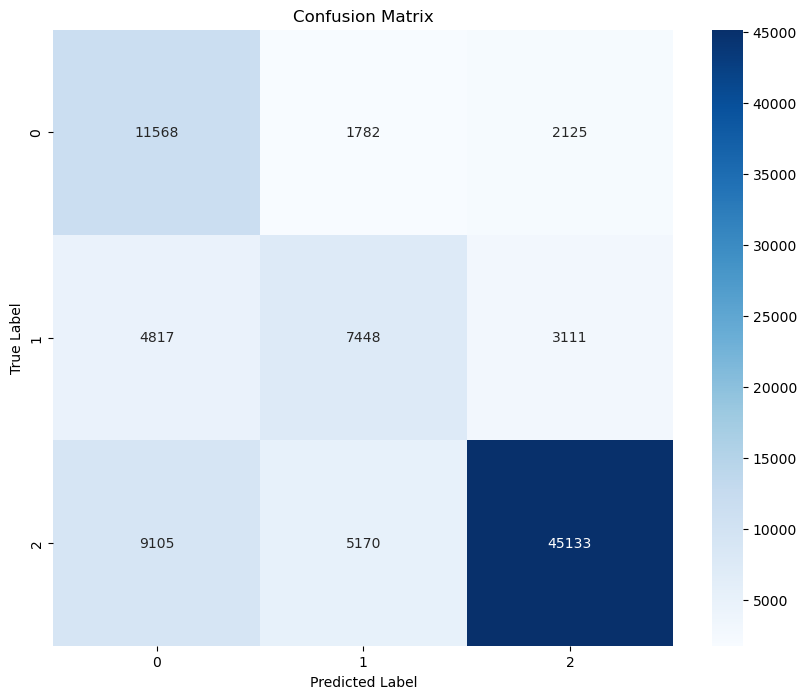

In [170]:
# Function to get the average Word2Vec embedding for a tweet
def get_average_word2vec(tokens, model, vector_size):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Convert X_train and X_test to Word2Vec embeddings
X_train_w2v = np.array([get_average_word2vec(text.split(), word2vec_model, 300) for text in X_train])
X_test_w2v = np.array([get_average_word2vec(text.split(), word2vec_model, 300) for text in X_test])

# Train the SVM model on Word2Vec embeddings
svm_w2v_skipgram = LinearSVC()
svm_w2v_skipgram.fit(X_train_w2v, y_train)

# Predict and evaluate
y_pred = svm_w2v_skipgram.predict(X_test_w2v)
print("SVM with Word2Vec Embeddings")

evaluate_model(svm_w2v_skipgram, X_test_w2v, y_test)

plot_confusion_matrix(y_test, y_pred)


In [173]:
with open('word2vec_model.pkl', 'wb') as file:
    pickle.dump(word2vec_model, file)

In [171]:
with open('svm_w2v_skipgram.pkl', 'wb') as file:
    pickle.dump(svm_w2v_skipgram, file)

####  SVM Model using any other word embedding (GloVe, Fasttext or ELMo)

In [158]:
# Load pre-trained GloVe embeddings (assuming you have them in a file)
glove_embeddings = {}
with open('glove.6B/glove.6B.300d.txt', 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        glove_embeddings[word] = vector

# Function to get average GloVe embedding for a tweet
def get_average_glove(tokens, embeddings, vector_size):
    vectors = [embeddings[token] for token in tokens if token in embeddings]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Convert X_train and X_test to GloVe embeddings
X_train_glove = np.array([get_average_glove(text.split(), glove_embeddings, 300) for text in X_train])
X_test_glove = np.array([get_average_glove(text.split(), glove_embeddings, 300) for text in X_test])

# Train the SVM model on GloVe embeddings
svm_glove = LinearSVC()
svm_glove.fit(X_train_glove, y_train)

# Predict and evaluate
y_pred = svm_glove.predict(X_test_glove)
print("SVM with GloVe Embeddings")
print(classification_report(y_test, y_pred))


SVM with GloVe Embeddings
              precision    recall  f1-score   support

    Negative       0.44      0.73      0.55     15475
     Neutral       0.42      0.43      0.43     15376
    Positive       0.88      0.72      0.79     59408

    accuracy                           0.67     90259
   macro avg       0.58      0.63      0.59     90259
weighted avg       0.73      0.67      0.69     90259



In [159]:
evaluate_model(svm_glove, X_test_glove, y_test)

Accuracy:  0.6736502731029592
Precision:  0.7272347032278593
Recall:  0.6736502731029592
F1 score:  0.6886692065378196
F1 Score (Positive):  0.5890964914533148
F1 Score (Negative):  0.5890964914533148
F1 Score (Neutral):  0.5890964914533148
Confusion matrix: 
 [[11360  2054  2061]
 [ 5090  6628  3658]
 [ 9480  7113 42815]]
Classification report: 
               precision    recall  f1-score   support

    Negative       0.44      0.73      0.55     15475
     Neutral       0.42      0.43      0.43     15376
    Positive       0.88      0.72      0.79     59408

    accuracy                           0.67     90259
   macro avg       0.58      0.63      0.59     90259
weighted avg       0.73      0.67      0.69     90259



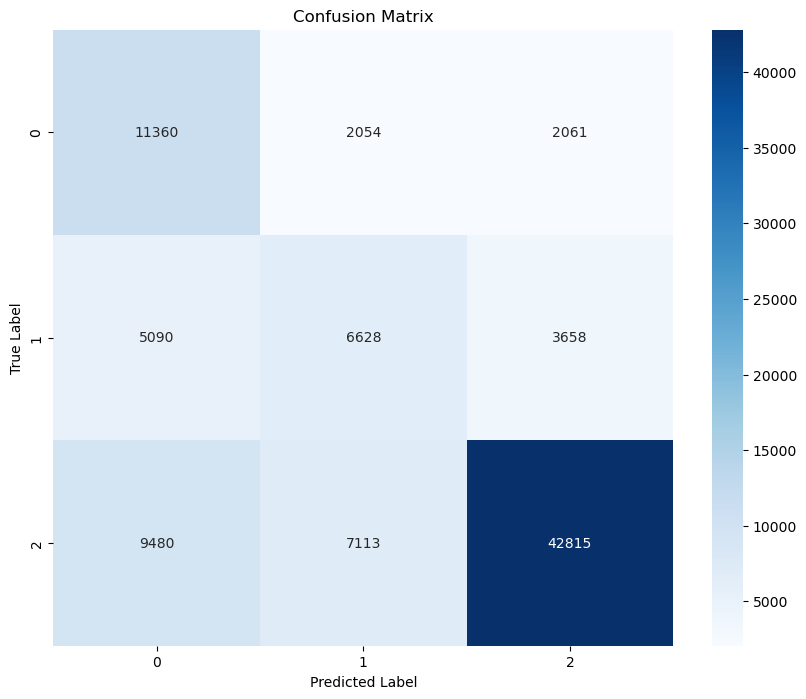

In [160]:
plot_confusion_matrix(y_test, y_pred)

In [172]:
with open('svm_glove.pkl', 'wb') as file:
    pickle.dump(svm_glove, file)